# Demo - White Attack with Imagenet

In [1]:
import numpy as np
import json
import os
import sys
import glob
import time
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
class CIFAR_model(nn.Module):
    def __init__(self):
        super(CIFAR_model, self).__init__()
        self.convblock = nn.Sequential(
            # Block 1
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # Block 2
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.Conv2d(128,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.fcblock = nn.Sequential(
            # FC Block
            nn.Linear(128*5*5, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.convblock(x)
        x = x.view(-1, 128*5*5)
        x = self.fcblock(x)
        return x
    
    def __str__(self):
        return "CIFAR_model"

In [5]:
model = CIFAR_model().cuda()
model.load_state_dict(torch.load("./models/CIFAR_model.state"))
model.eval()

CIFAR_model(
  (convblock): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcblock): Sequential(
    (0): Linear(in_features=3200, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [6]:
d = []
gt = []

for filename in glob.glob('./confident_input/CIFAR_model/' + '*.data'):
    img = torch.load(filename)
    modelout = model(img[None,...])
    INITCONF, TRUECLASS = torch.max(modelout, 1)
    #print(TRUECLASS)
    #print(CIFAR_CLASSES[TRUECLASS])
    d.append(img)
    gt.append(TRUECLASS)
    
print(len(d))
print(len(gt))

216
216


In [7]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    #plt.title(title)
    plt.show()

In [8]:
CIFAR_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

## 1. Load Data

In [13]:
# First white box attack BIM
# change iters increase attack success rate but increase L2 loss
# iter = 0 80

BIM_time = []
BIM_L2 = []
BIM_output = []
BIM_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=40)
for i in range(len(d)):
    t0 = time.time()
    images = BIM(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    BIM_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    BIM_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    BIM_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        BIM_correct+=1
        
print(BIM_correct)
average_time = np.sum(np.array(BIM_time))/len(d)
average_L2 = np.sum(np.array(BIM_L2))/len(d)
print(average_time)
print(average_L2)

204
0.2686840174374757
tensor([25.5609], device='cuda:0')


In [15]:
# then try white box attack StepLL = torchattacks.StepLL(model, eps=4/255, alpha=1/255, iters=0)
StepLL_time = []
StepLL_L2 = []
StepLL_output = []
StepLL_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
StepLL = torchattacks.StepLL(model, eps=4/255, alpha=1/255, iters=10)
for i in range(len(d)):
    t0 = time.time()
    images = StepLL(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    StepLL_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    StepLL_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    StepLL_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        StepLL_correct+=1
        
print(StepLL_correct)
average_time = np.sum(np.array(StepLL_time))/len(d)
average_L2 = np.sum(np.array(StepLL_L2))/len(d)
print(average_time)
print(average_L2)

34
0.07082464628749424
tensor([14.1452], device='cuda:0')


In [16]:
# then try white box attack RFGSM
StepLL_time = []
StepLL_L2 = []
StepLL_output = []
StepLL_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
RFGSM = torchattacks.RFGSM(model, eps=16/255, alpha=8/255, iters=5)
for i in range(len(d)):
    t0 = time.time()
    images = RFGSM(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    StepLL_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    StepLL_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    StepLL_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        StepLL_correct+=1
        
print(StepLL_correct)
average_time = np.sum(np.array(StepLL_time))/len(d)
average_L2 = np.sum(np.array(StepLL_L2))/len(d)
print(average_time)
print(average_L2)

216
0.02826858891381158
tensor([38.3447], device='cuda:0')


In [18]:
# PGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=40)
# then try white box attack RFGSM
StepLL_time = []
StepLL_L2 = []
StepLL_output = []
StepLL_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
PGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=40)
for i in range(len(d)):
    t0 = time.time()
    images = PGD(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    StepLL_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    StepLL_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    StepLL_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        StepLL_correct+=1
        
print(StepLL_correct)
average_time = np.sum(np.array(StepLL_time))/len(d)
average_L2 = np.sum(np.array(StepLL_L2))/len(d)
print(average_time)
print(average_L2)

216
0.24012919708534522
tensor([37.1240], device='cuda:0')


In [19]:
# RPGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=40, random_start=True)
StepLL_time = []
StepLL_L2 = []
StepLL_output = []
StepLL_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
RPGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=40, random_start=True)
for i in range(len(d)):
    t0 = time.time()
    images = RPGD(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    StepLL_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    StepLL_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    StepLL_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        StepLL_correct+=1
        
print(StepLL_correct)
average_time = np.sum(np.array(StepLL_time))/len(d)
average_L2 = np.sum(np.array(StepLL_L2))/len(d)
print(average_time)
print(average_L2)

216
0.24318546056747437
tensor([37.3128], device='cuda:0')


In [20]:
# DeepFool = torchattacks.DeepFool(model, iters=10)
StepLL_time = []
StepLL_L2 = []
StepLL_output = []
StepLL_correct = 0
#BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, iters=0)
DeepFool = torchattacks.DeepFool(model, iters=10)
for i in range(len(d)):
    t0 = time.time()
    images = DeepFool(d[i][None,...], gt[i])
    #print(gt[i])
    dt = time.time() - t0
    StepLL_time.append(dt)
    outputs = model(images)
    
    L2 = torch.norm(images.view(1,-1) - d[i].view(1,-1), dim=1)
    #print(L2)
    StepLL_L2.append(L2)
    
    _, pre = torch.max(outputs.data, 1)
    StepLL_output.append(pre)
    #print(pre)
    if gt[i] != pre:
        StepLL_correct+=1
        
print(StepLL_correct)
average_time = np.sum(np.array(StepLL_time))/len(d)
average_L2 = np.sum(np.array(StepLL_L2))/len(d)
print(average_time)
print(average_L2)

203
0.1070918771955702
tensor([0.], device='cuda:0')


## END

In [19]:
# test a deer
modelout = model(data[None,...])
INITCONF, TRUECLASS = torch.max(modelout, 1)
print(TRUECLASS)
print(CIFAR_CLASSES[TRUECLASS])

tensor([4], device='cuda:0')
deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.04505348205566406
tensor([2], device='cuda:0')
bird


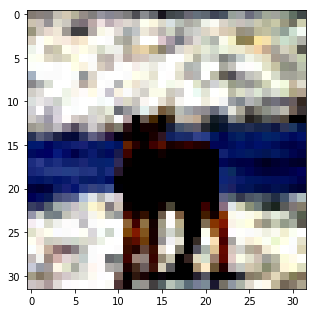

In [25]:
t0 = time.time()
images = BIM(data[None,...], TRUECLASS[...])
dt = time.time() - t0
print(dt)
#labels = labels.to(device)
outputs = model(images)

_, pre = torch.max(outputs.data, 1)
print(pre)
print(CIFAR_CLASSES[pre])
imshow(images.squeeze().cpu())